In [ ]:
# !pip install graphviz
# !brew install graphviz

In [250]:
from graphviz import Digraph
import math 
import random

In [67]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [187]:
def gradient_check(h=0.0000001):
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    e_ = Value(0.01, label='e_')
    f = Value(-2.0, label='f') + e * e_
    g = d * f; g.label='g'
    j = Value(-7.0, label='j')
    i = g-j; i.label='i'
    o = i.tanh(); o.label='o'

    a = Value(2.0, label='a') + h
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    e_ = Value(0.01, label='e_')
    f = Value(-2.0, label='f') + e * e_
    g = d * f; g.label='g'
    j = Value(-7.0, label='j')
    i = g-j; i.label='i'
    o_ = i.tanh(); o_.label='o_'
    
    grad = (o_.data - o.data) / h # (f(x+h)-f(x)) / h 
    print(f"grad = {grad:.12f}")

In [281]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data 
        self._prev = set(_children)
        self._op = _op 
        self.label = label 
        self.grad = 0 
        self._backward = lambda: None 

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)  
        out = Value(self.data + other.data, (self, other), '+')
        def backward():
            other.grad += out.grad * 1.0 
            self.grad += out.grad * 1.0 
        out._backward = backward 
        return out 
        
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)  
        out = Value(self.data * other.data, (self, other), '*')
        def backward():
            other.grad += out.grad * self.data 
            self.grad += out.grad * other.data 
        out._backward = backward 
        return out 

    def __rmul__(self, other):
        return self * other 

    def __radd__(self, other):
        return self + other 

    def __neg__(self):
        return self * -1 

    def __sub__(self, other):
        return self + (-other)

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers"
        out = Value(self.data ** other, (self,), f'**{other}')
        def backward():
            self.grad += out.grad * other * (self.data ** (other-1))
        out._backward = backward
        return out 

    def __truediv__(self, other):
        return self * other ** -1 

    def exp(self):
        x = self.data
        t = math.exp(x)
        out = Value(t, (self, ), 'exp')
        def backward():
            self.grad += out.grad * t 
        out._backward = backward
        return out
    
    def tanh(self):
        # x = self.data 
        # t = (math.exp(2*x)-1) / (math.exp(2*x)+1)
        # out = Value(t, (self, ), 'tanh')
        # def backward():
        #     self.grad += out.grad * (1.0 - t ** 2)
        # out._backward = backward
        # return out
        tmp = 2 * self 
        return (tmp.exp() - 1) / (tmp.exp() + 1)

    def backward(self):
        self.grad = 1.0 # the first node for backprop
        visited = set()
        topo = []
        def build_topo(v):
            if v in visited:
                return 
            visited.add(v)
            for child in v._prev:
                build_topo(child)
            topo.append(v)
        build_topo(self)        
        for node in reversed(topo):
            node._backward()
        

In [334]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs 
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        
class MLP:
    def __init__(self, nin, nouts):
        szs = [nin] + nouts
        self.layers = [Layer(szs[i], szs[i+1]) for i in range(len(szs)-1)]
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x 
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [245]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d = e+c; d.label='d'
e_ = Value(0.01, label='e_')
ee_ = e * e_; ee_.label='ee_'
f = Value(-2.0, label='f') + ee_
g = d * f; g.label='g'
j = Value(-7.0, label='j')
i = g-j; i.label='i'
o = i.tanh(); o.label='o'

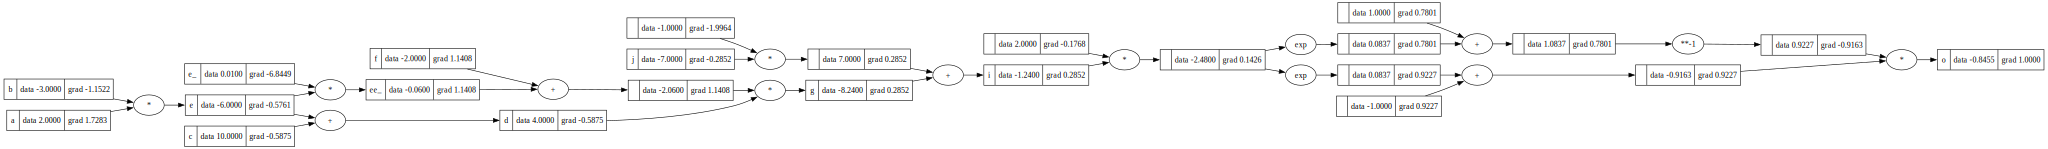

In [236]:
draw_dot(o)

In [190]:
gradient_check()

grad = 1.728342196028


In [246]:
o.backward()
print(a.grad)

1.7283413040659314


In [350]:
n = MLP(3, [4,4,1])
x = [2.0, 3.0, -1.0]
y = n(x)

In [341]:
# draw_dot(y)

In [351]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
] 
ys = [1.0, -1.0, -1.0, 1.0]

[Value(data=0.9411756539959525), Value(data=-0.9319975310371594), Value(data=-0.9209659719236147), Value(data=0.9032840752343023)]


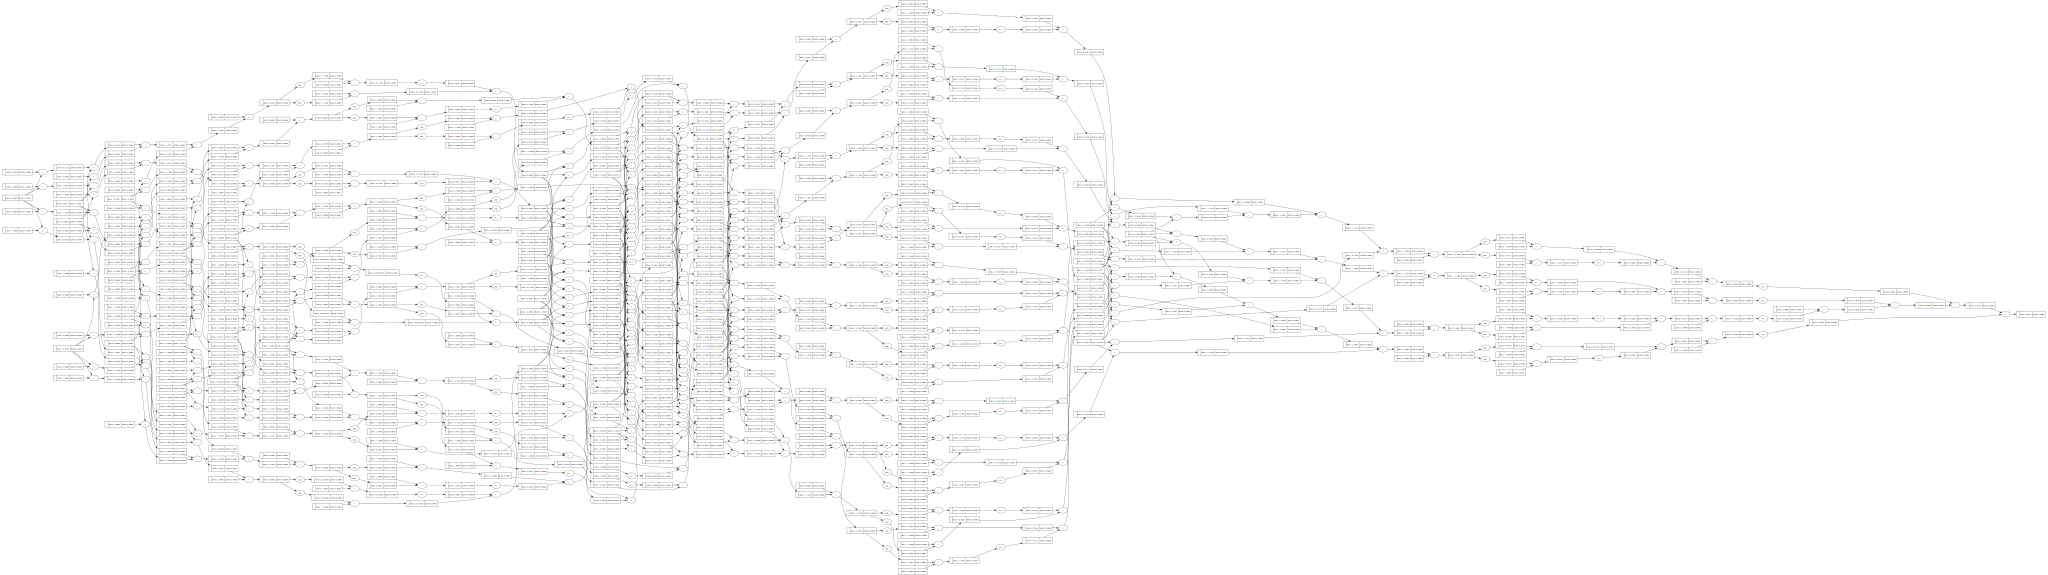

In [355]:
y_preds = [n(x) for x in xs]
print(y_preds)
loss = sum((y_pred - y)**2 for y_pred, y in zip(y_preds, ys))
draw_dot(loss)

In [353]:
for k in range(50):
    y_preds = [n(x) for x in xs]
    loss = sum((y_pred - y)**2 for y_pred, y in zip(y_preds, ys))
    
    for p in n.parameters():
        p.grad = 0.0 
        
    loss.backward()
    
    for p in n.parameters():
        p.data += - 0.05 * p.grad 
        
    print(k, loss.data)

0 5.842024034141123
1 4.224703801575422
2 2.8649722215530176
3 1.800435780056857
4 1.0916124170328811
5 0.7020321711823208
6 0.492912495415382
7 0.37157753296323576
8 0.29470965243425984
9 0.2424645762563557
10 0.20497473021352963
11 0.17691861653942714
12 0.1552158144529266
13 0.1379752558240022
14 0.12397830729915675
15 0.11240734124942728
16 0.10269487224626556
17 0.09443552776818553
18 0.08733249464704193
19 0.08116374384244027
20 0.07576005056839774
21 0.07099029186234687
22 0.06675137050848326
23 0.06296115903903443
24 0.059553462435541174
25 0.056474359121144735
26 0.05367950117391569
27 0.05113209378033326
28 0.04880136331497809
29 0.04666138202509834
30 0.044690156430758715
31 0.04286891313292435
32 0.04118153406197657
33 0.0396141060365227
34 0.038154558608580615
35 0.03679237071117034
36 0.0355183313756765
37 0.034324343275533506
38 0.03320326044100238
39 0.03214875342787808
40 0.0311551966871063
41 0.030217573997636096
42 0.029331398681184805
43 0.02849264597996377
44 0.027

In [354]:
y_preds

[Value(data=0.9404261382629222),
 Value(data=-0.9312871194210716),
 Value(data=-0.9199711702869102),
 Value(data=0.9020163416233054)]